In [6]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import yfinance as yf


In [7]:
# Define the ticker symbol
ticker = 'AAPL'

# Get data on this ticker
stock_data = yf.Ticker(ticker)

# Get historical market data
hist = stock_data.history(period="5y")  # Last 5 years of data

# Display the first few rows
hist.head()


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-10-23 00:00:00-04:00,58.566670,58.842448,58.353787,58.827930,75828800,0.0,0.0
2019-10-24 00:00:00-04:00,59.149666,59.219822,58.496507,58.924690,69275200,0.0,0.0
2019-10-25 00:00:00-04:00,58.823082,59.686703,58.755347,59.650417,73477200,0.0,0.0
2019-10-28 00:00:00-04:00,59.853616,60.296314,59.684279,60.247932,96572800,0.0,0.0
2019-10-29 00:00:00-04:00,60.228587,60.417277,58.680358,58.854530,142839600,0.0,0.0


In [10]:
# Get the market capitalization (market value of equity)
market_cap = stock_data.info['marketCap']
print(f"Market Capitalization: {market_cap}")

# Get the total debt
total_debt = stock_data.balance_sheet.loc['Total Debt'].iloc[0]
print(f"Total Debt: {total_debt}")

# Get the risk-free rate (for simplicity, we can use a constant value, e.g., 0.05 for 5%)
risk_free_rate = 0.05
print(f"Risk-Free Rate: {risk_free_rate}")

# Get the volatility (standard deviation of daily returns)
hist['Daily Return'] = hist['Close'].pct_change()
volatility = hist['Daily Return'].std() * np.sqrt(252)  # Annualized volatility
print(f"Volatility: {volatility}")


Market Capitalization: 3586038956032
Total Debt: 123930000000.0
Risk-Free Rate: 0.05
Volatility: 0.3170959655727544


In [12]:
V = market_cap  # Asset value (market cap)
D = total_debt  # Debt value
r = risk_free_rate  # Risk-free rate
T = 1  # Time to maturity (1 year)
sigma = volatility  # Volatility

print(f"Asset Value (V): {V}")
print(f"Debt Value (D): {D}")
print(f"Risk-Free Rate (r): {r}")
print(f"Time to Maturity (T): {T}")
print(f"Volatility (sigma): {sigma}")


Asset Value (V): 3586038956032
Debt Value (D): 123930000000.0
Risk-Free Rate (r): 0.05
Time to Maturity (T): 1
Volatility (sigma): 0.3170959655727544


In [13]:
d1 = (np.log(V / D) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
d2 = d1 - sigma * np.sqrt(T)

print(f"d1: {d1}")
print(f"d2: {d2}")


d1: 10.928431545408236
d2: 10.611335579835481


In [14]:
PD = norm.cdf(-d2)
print(f"Probability of Default: {PD:.4f}")


Probability of Default: 0.0000


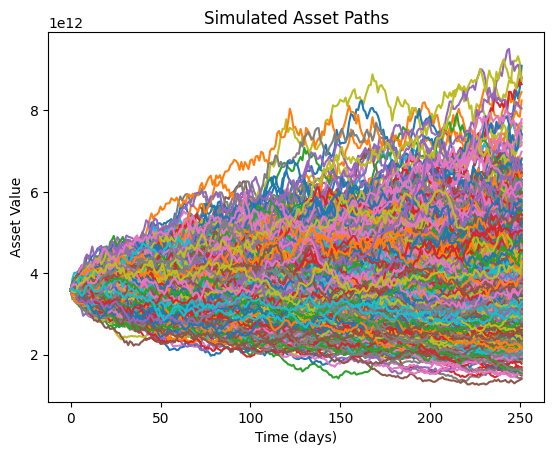

In [15]:
np.random.seed(42)
num_simulations = 1000
time_horizon = 252  # Number of trading days in a year

dt = T / time_horizon
asset_paths = np.zeros((num_simulations, time_horizon))
asset_paths[:, 0] = V

for t in range(1, time_horizon):
    z = np.random.standard_normal(num_simulations)
    asset_paths[:, t] = asset_paths[:, t-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)

plt.plot(asset_paths.T)
plt.title('Simulated Asset Paths')
plt.xlabel('Time (days)')
plt.ylabel('Asset Value')
plt.show()


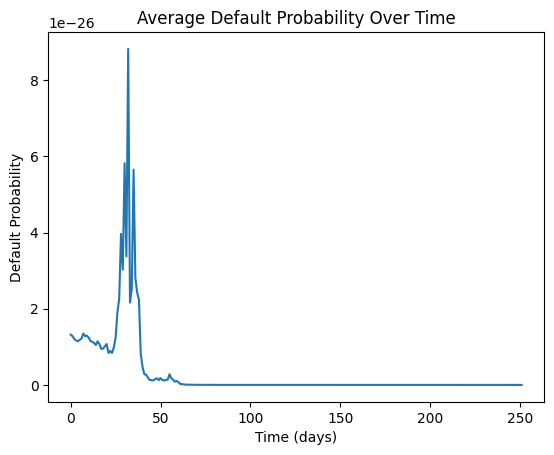

In [16]:
default_probabilities = np.zeros((num_simulations, time_horizon))

for t in range(time_horizon):
    V_t = asset_paths[:, t]
    d1_t = (np.log(V_t / D) + (r + 0.5 * sigma**2) * (T - t * dt)) / (sigma * np.sqrt(T - t * dt))
    d2_t = d1_t - sigma * np.sqrt(T - t * dt)
    default_probabilities[:, t] = norm.cdf(-d2_t)

# Average default probability at each time step
avg_default_probabilities = np.mean(default_probabilities, axis=0)

plt.plot(avg_default_probabilities)
plt.title('Average Default Probability Over Time')
plt.xlabel('Time (days)')
plt.ylabel('Default Probability')
plt.show()


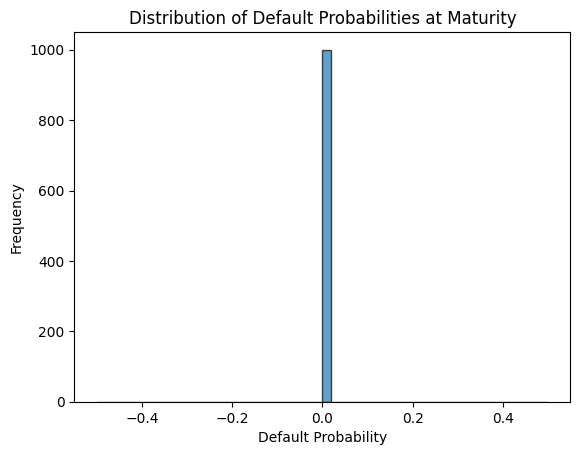

In [17]:
plt.hist(default_probabilities[:, -1], bins=50, edgecolor='k', alpha=0.7)
plt.title('Distribution of Default Probabilities at Maturity')
plt.xlabel('Default Probability')
plt.ylabel('Frequency')
plt.show()


In [18]:
final_default_probabilities = default_probabilities[:, -1]
mean_default_probability = np.mean(final_default_probabilities)
median_default_probability = np.median(final_default_probabilities)
std_default_probability = np.std(final_default_probabilities)

print(f"Mean Default Probability: {mean_default_probability:.4f}")
print(f"Median Default Probability: {median_default_probability:.4f}")
print(f"Standard Deviation of Default Probability: {std_default_probability:.4f}")


Mean Default Probability: 0.0000
Median Default Probability: 0.0000
Standard Deviation of Default Probability: 0.0000


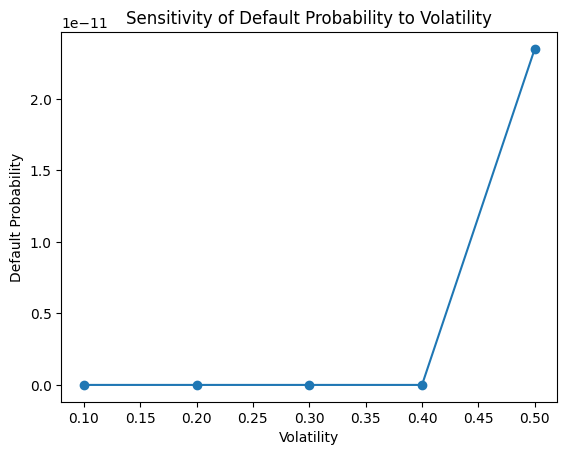

In [19]:
volatilities = np.linspace(0.1, 0.5, 5)
sensitivity_results = []

for vol in volatilities:
    d1 = (np.log(V / D) + (r + 0.5 * vol**2) * T) / (vol * np.sqrt(T))
    d2 = d1 - vol * np.sqrt(T)
    PD = norm.cdf(-d2)
    sensitivity_results.append(PD)

plt.plot(volatilities, sensitivity_results, marker='o')
plt.title('Sensitivity of Default Probability to Volatility')
plt.xlabel('Volatility')
plt.ylabel('Default Probability')
plt.show()
